[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [2]:
%%capture --no-stderr
%pip install -U langchain_groq langgraph


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [5]:
from langchain_groq import ChatGroq

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatGroq(model="openai/gpt-oss-120b", 
                 api_key = os.environ["GROQ_API_KEY"],
                 temperature=0)

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [6]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

Generate subjects for jokes.

In [7]:
import json

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"]) + "\n\nPlease return the list of subjects as a JSON object with a single key 'subjects' containing a list of strings."
    response = model.invoke(prompt)
    try:
        subjects_data = json.loads(response.content)
        return {"subjects": subjects_data.get("subjects", [])}
    except json.JSONDecodeError:
        print("Could not parse JSON response for subjects.")
        return {"subjects": []}

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [8]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [9]:
import json

class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"]) + "\n\nPlease return the joke as a JSON object with a single key 'joke' containing the joke string."
    response = model.invoke(prompt)
    try:
        joke_data = json.loads(response.content)
        return {"jokes": [joke_data.get("joke", "")]}
    except json.JSONDecodeError:
        print(f"Could not parse JSON response for joke about {state['subject']}.")
        return {"jokes": [""]}

### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [10]:
import json

def best_joke(state: OverallState):
    jokes = "\n\n".join([f"{i}: {joke}" for i, joke in enumerate(state["jokes"])])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes) + "\n\nPlease return the ID of the best joke as a JSON object with a single key 'id' containing an integer."
    response = model.invoke(prompt)
    try:
        best_joke_data = json.loads(response.content)
        selected_id = best_joke_data.get("id")
        if selected_id is not None and 0 <= selected_id < len(state["jokes"]):
            return {"best_selected_joke": state["jokes"][selected_id]}
        else:
            print("Could not determine the best joke ID from the JSON response.")
            return {"best_selected_joke": "Could not select a joke."}
    except json.JSONDecodeError:
        print("Could not parse JSON response for best joke selection.")
        return {"best_selected_joke": "Could not select a joke."}

## Compile

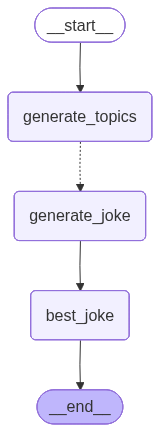

In [11]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [12]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Mammalian behavior and social structures', 'Endangered species conservation', 'Adaptations of marine life']}}
{'generate_joke': {'jokes': ['Why did the endangered panda start a podcast? Because it wanted to raise awareness—one bamboo episode at a time!']}}
{'generate_joke': {'jokes': ["Why did the fish bring a ladder to the coral reef? Because it heard the reef was developing a new 'upward' adaptation and wanted to stay a step ahead!"]}}
{'generate_joke': {'jokes': ["Why did the meerkat start a support group? Because it heard that in mammalian societies, sharing the lookout duty is the best way to avoid feeling 'alone' in the herd!"]}}
{'best_joke': {'best_selected_joke': "Why did the fish bring a ladder to the coral reef? Because it heard the reef was developing a new 'upward' adaptation and wanted to stay a step ahead!"}}


Here is the input and output observed in `continue_to_jokes` under the `generate_topics` state in LangSmith traces:

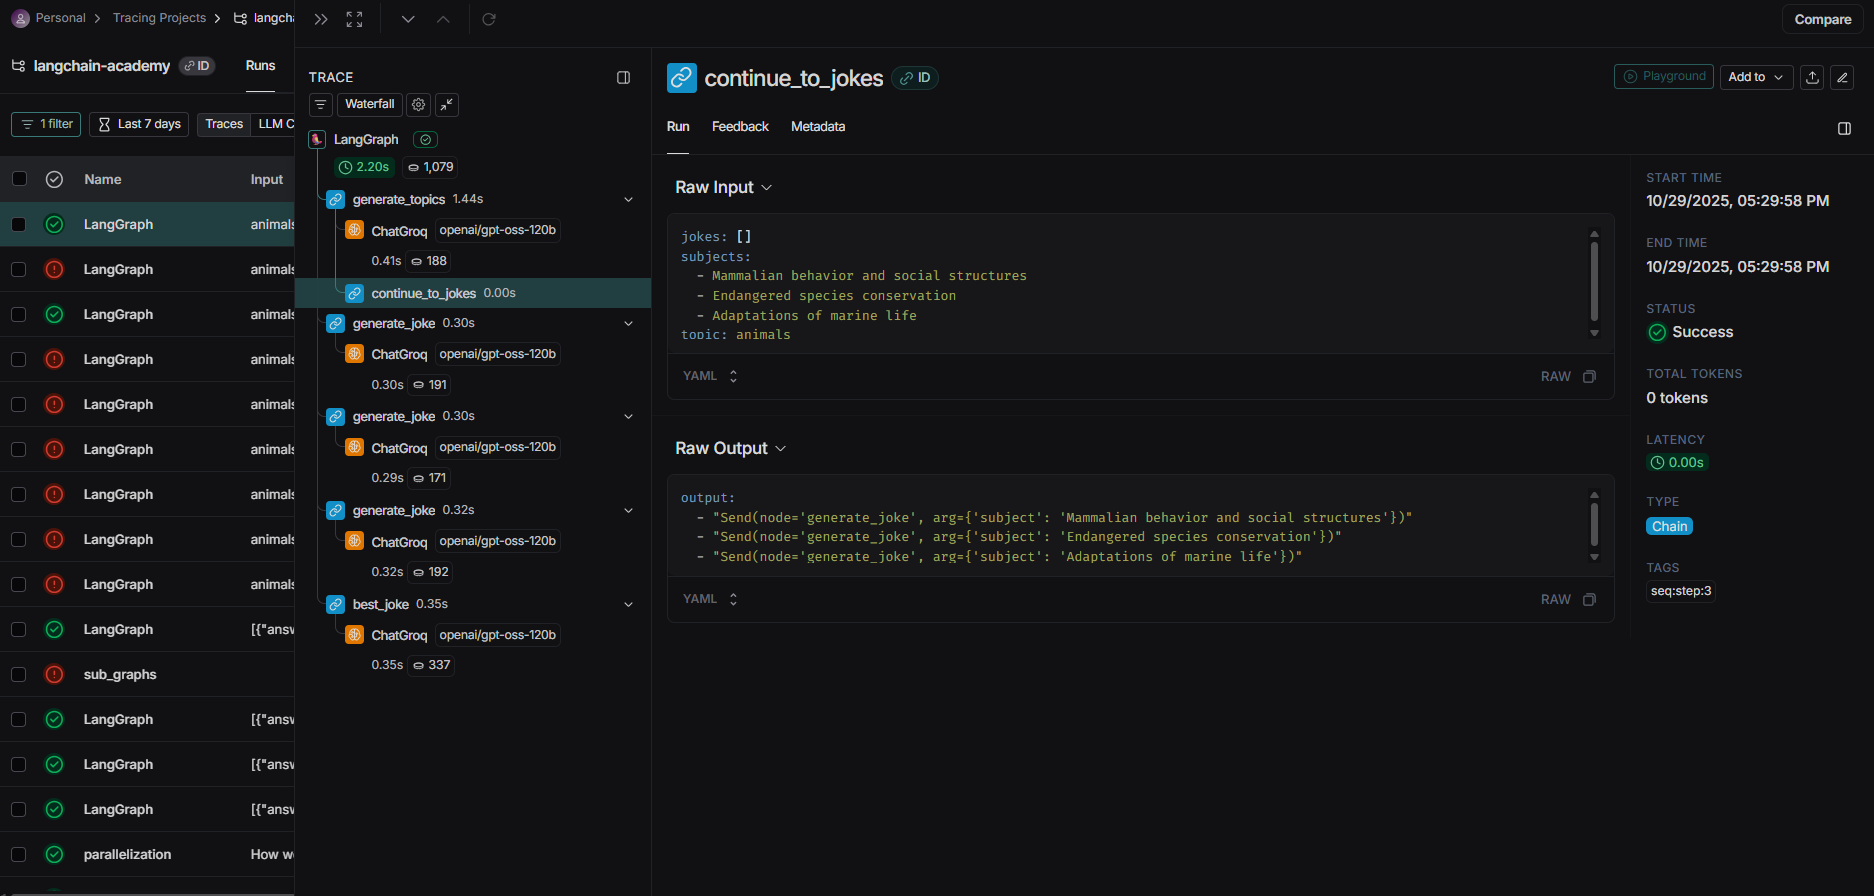

Output of one of the joke topic asked:

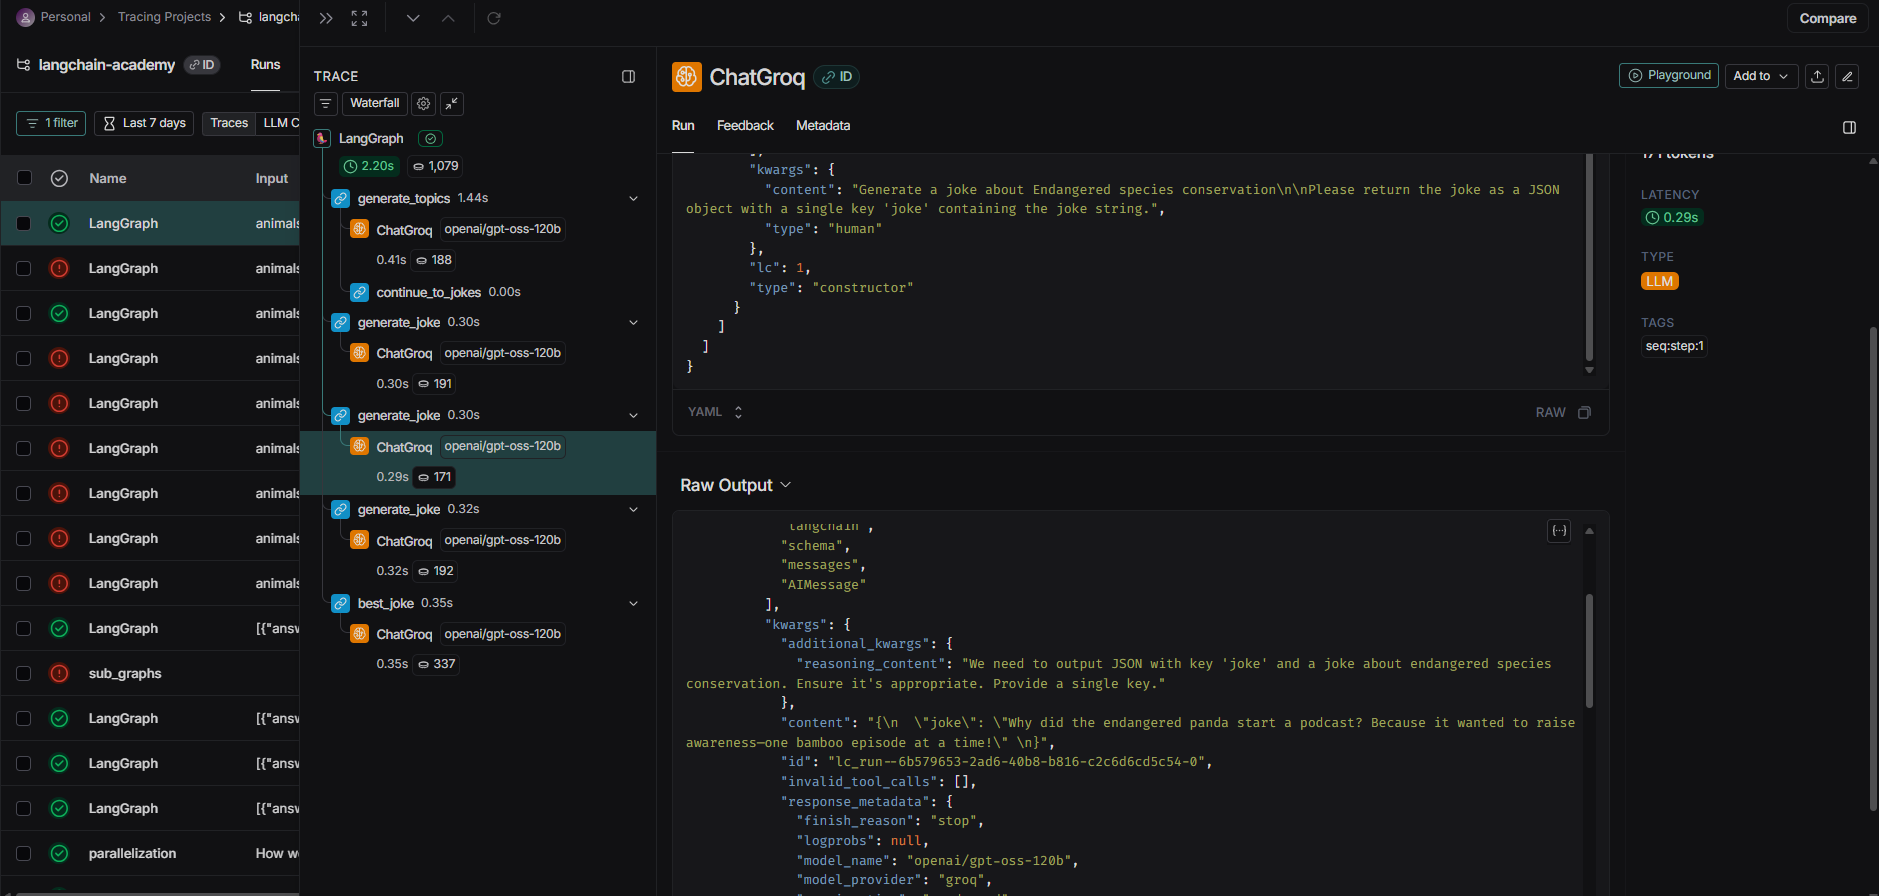

The best joke chosen by the model:

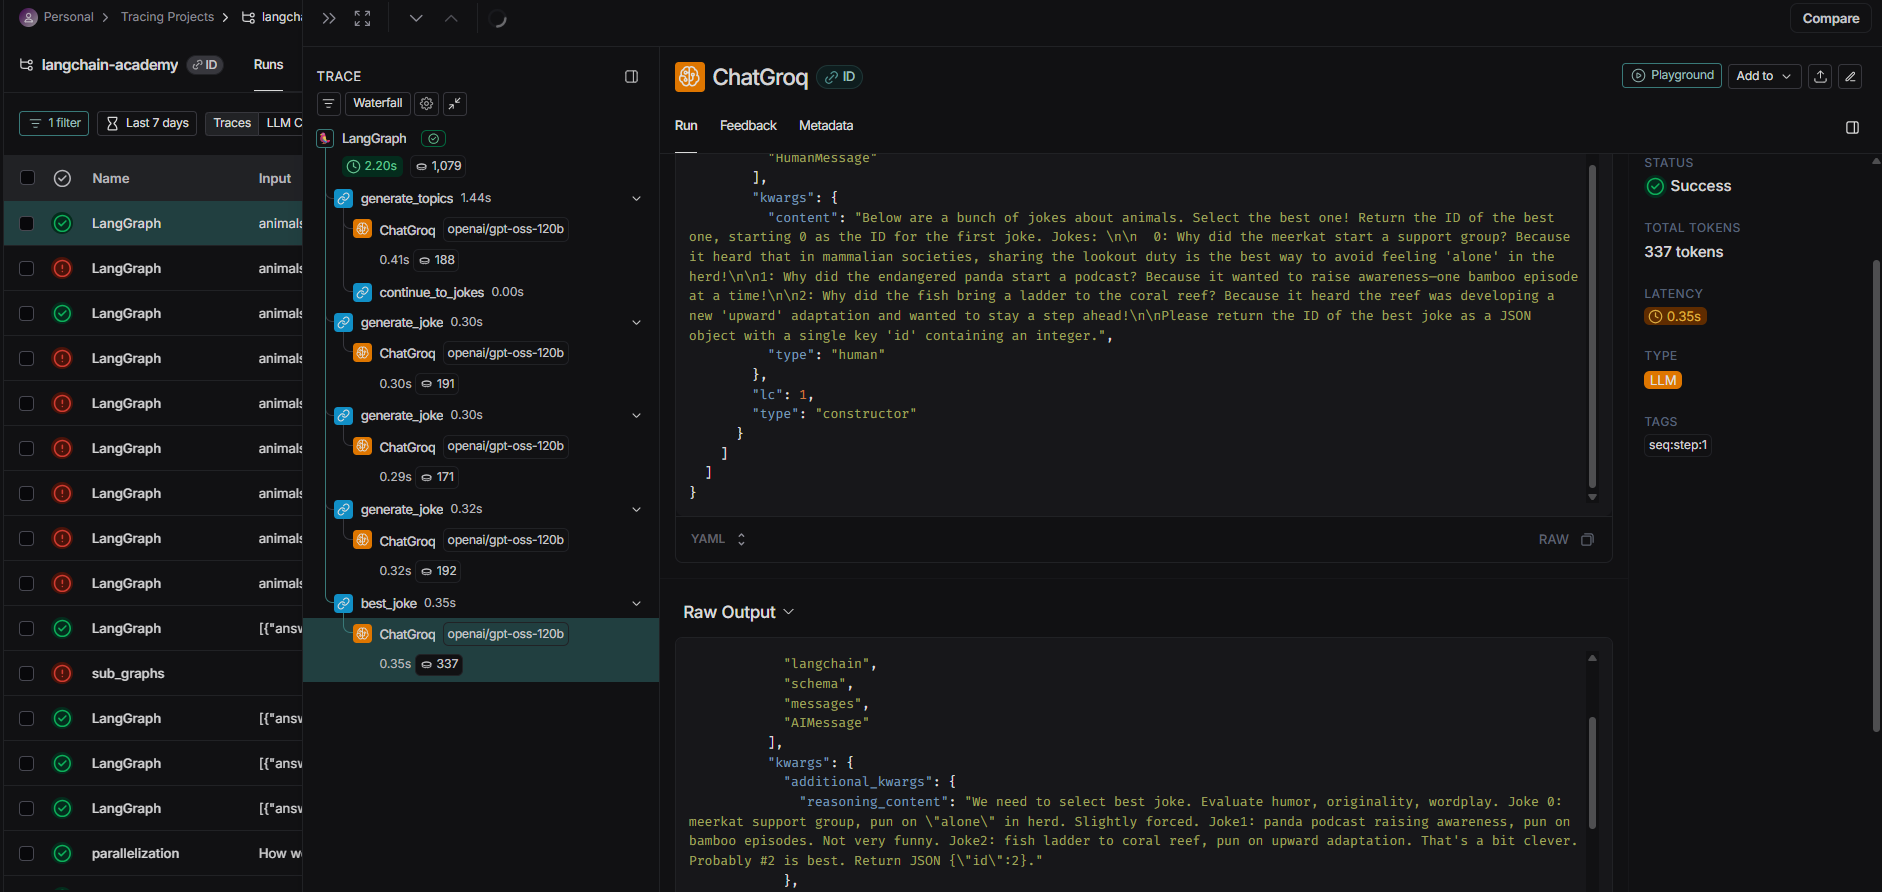

## Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.

After adding interrupt at the `generate_joke` state:

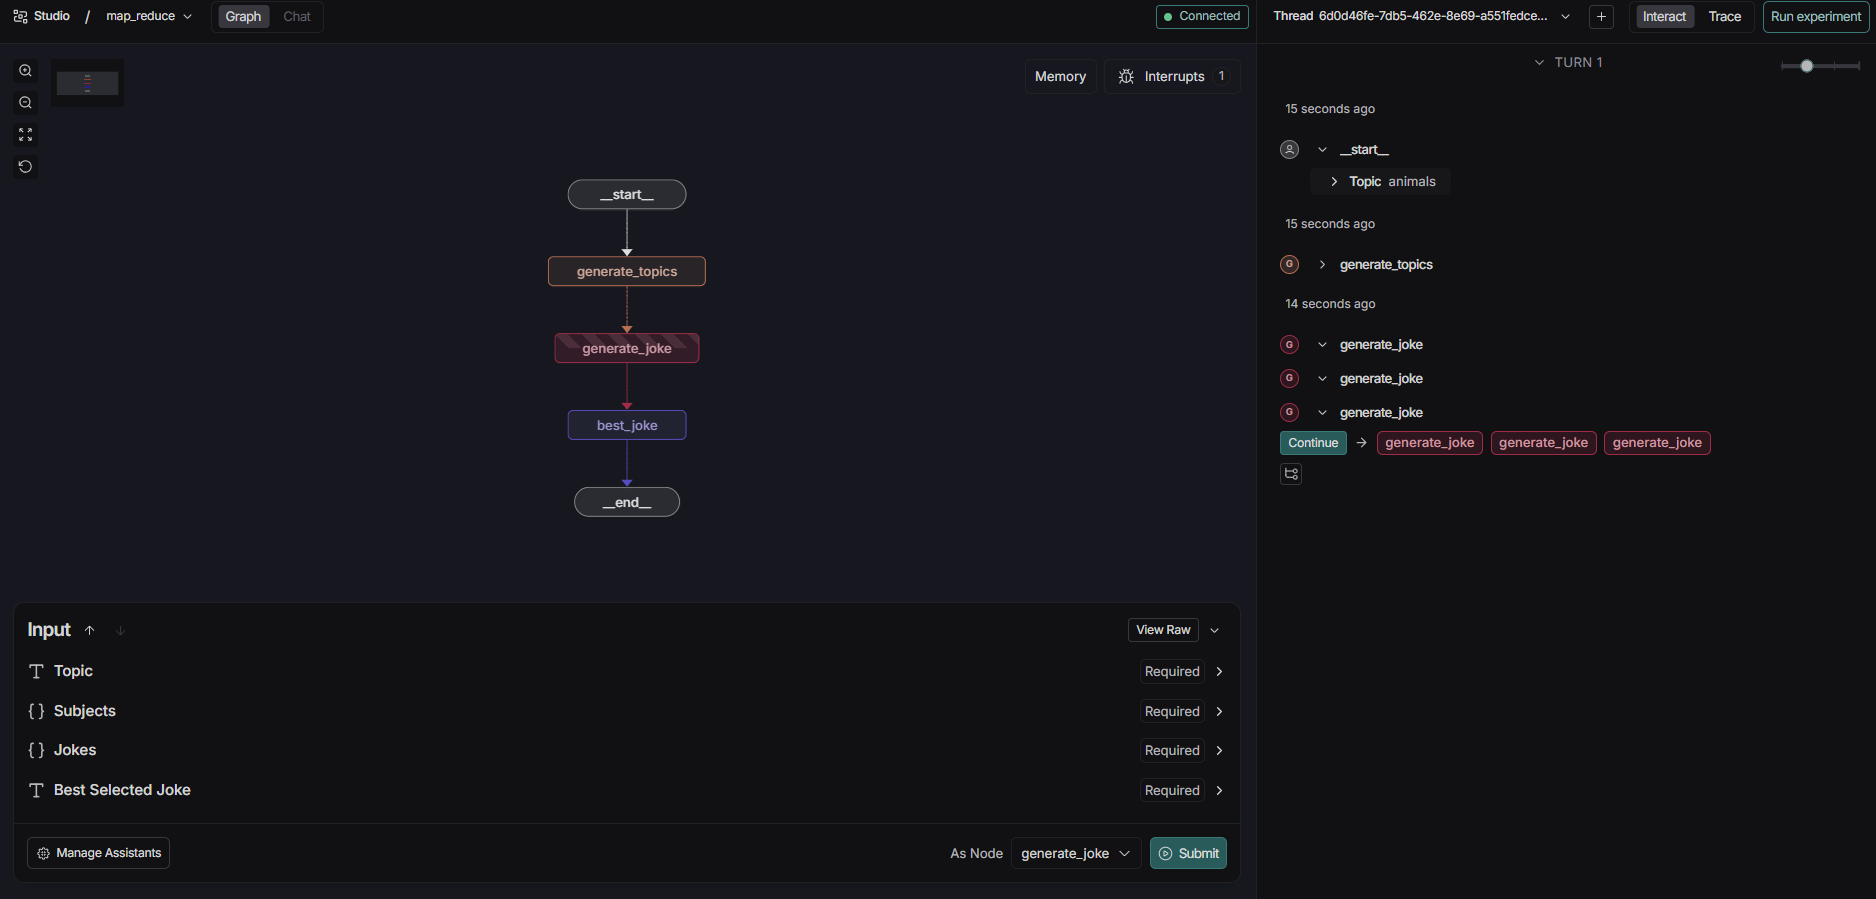

After clicking on `Continue`:

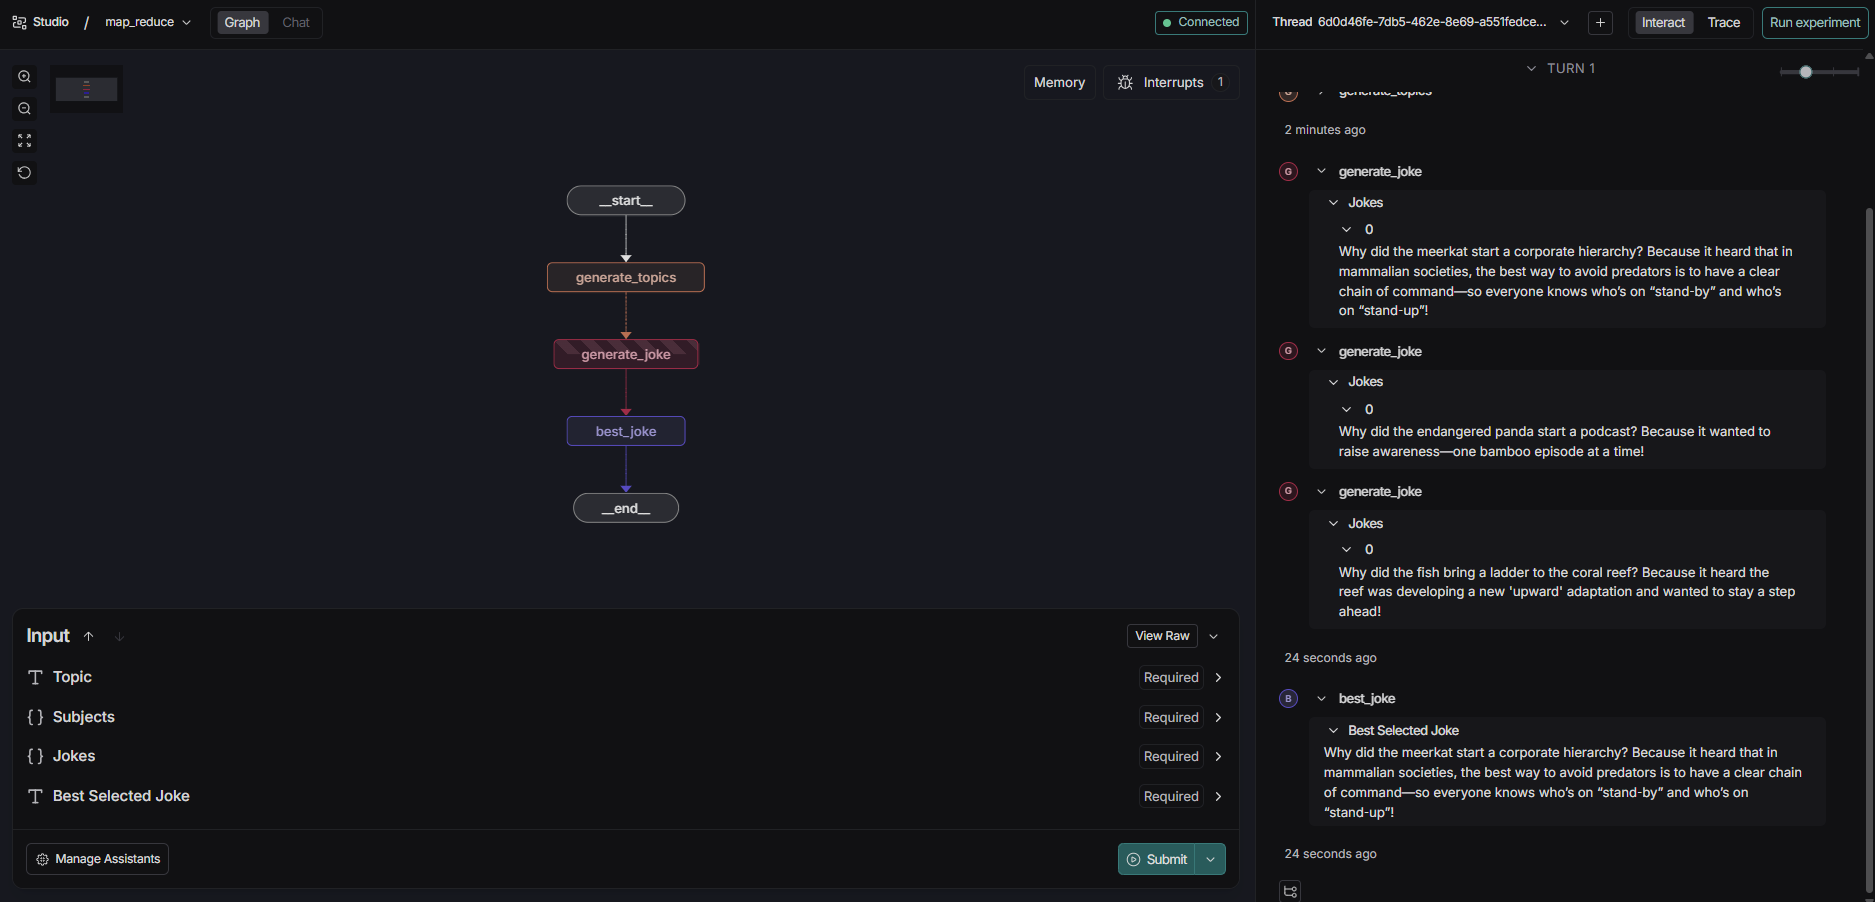

In [ ]:
import os, json
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
import operator

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_groq import ChatGroq
model = ChatGroq(model="openai/gpt-oss-120b", 
                 api_key=os.environ.get("GROQ_API_KEY"), 
                 temperature=0)


In [ ]:
class Personas(BaseModel):
    personas: list[str]

class Idea(BaseModel):
    idea: str

class EvalResult(BaseModel):
    idea: str
    persona: str
    impact: float
    feasibility: float
    score: float
class BestIdea(BaseModel):
    idea: str

class OverallState(TypedDict):
    product: str
    personas: list
    ideas: Annotated[list, operator.add]
    evaluations: Annotated[list, operator.add]
    best_per_persona: dict
    best_overall: str


In [15]:
personas_prompt = """
Given the product: {product}, generate a JSON array named "personas" listing 3 customer personas (short phrase each).
Example: {{ "personas": ["budget-conscious student", "power-user developer", "enterprise admin"] }}
"""

ideas_prompt = """
You are given a persona: {persona} and a product: {product}.
Return a JSON object with key "ideas" containing a list of 3 concise feature ideas tailored for this persona.
Example: {{ "ideas": ["...", "...", "..."] }}
"""

evaluate_prompt = """
You are given an idea: "{idea}" for persona "{persona}" and product "{product}".
Rate the idea on two numeric metrics 0.0-1.0 (impact, feasibility).
Return JSON: {{ "impact": 0.85, "feasibility": 0.4 }}
Keep numbers between 0 and 1.
"""


In [ ]:
def generate_personas(state: OverallState):
    prompt = personas_prompt.format(product=state["product"])
    response = model.invoke(prompt)
    try:
        data = json.loads(response.content)
        return {"personas": data.get("personas", [])}
    except json.JSONDecodeError:
        print("Failed to parse personas JSON. Falling back to defaults.")
        return {"personas": ["power-user", "casual user", "admin"]}


In [ ]:
def continue_to_ideas(state: OverallState):
    return [ Send("generate_ideas", {"product": state["product"], "persona": p}) for p in state["personas"] ]


In [ ]:
def generate_ideas(state):
    prompt = ideas_prompt.format(product=state["product"], persona=state["persona"])
    response = model.invoke(prompt)
    try:
        data = json.loads(response.content)
        ideas = data.get("ideas", [])
        annotated = [ {"idea": idea, "persona": state["persona"]} for idea in ideas ]
        return {"ideas": annotated}
    except json.JSONDecodeError:
        print(f"Failed to parse ideas for persona {state['persona']}")
        return {"ideas": []}


In [ ]:
def continue_to_evaluations(state: OverallState):
    sends = []
    for ai in state["ideas"]:
        sends.append(Send("evaluate_idea", {"product": state["product"], "idea": ai["idea"], "persona": ai["persona"]}))
    return sends


In [ ]:
def evaluate_idea(state):
    prompt = evaluate_prompt.format(product=state["product"], idea=state["idea"], persona=state["persona"])
    response = model.invoke(prompt)
    try:
        data = json.loads(response.content)
        impact = float(data.get("impact", 0.0))
        feasibility = float(data.get("feasibility", 0.0))
        score = 0.6 * impact + 0.4 * feasibility
        eval_result = {"idea": state["idea"], "persona": state["persona"], "impact": impact, "feasibility": feasibility, "score": score}
        return {"evaluations": [eval_result]}
    except json.JSONDecodeError:
        print(f"Failed to parse evaluation for idea: {state['idea']}")
        return {"evaluations": []}


In [ ]:
def select_best(state: OverallState):
    evals = state.get("evaluations", [])
    if not evals:
        return {"best_per_persona": {}, "best_overall": "No evaluations available"}
    
    # best overall by score
    best_overall = max(evals, key=lambda e: e["score"])
    
    # best per persona
    from collections import defaultdict
    per_persona = defaultdict(list)
    for e in evals:
        per_persona[e["persona"]].append(e)
    best_per = { persona: max(items, key=lambda x: x["score"]) for persona, items in per_persona.items() }
    
    return {
        "best_per_persona": best_per,
        "best_overall": best_overall["idea"]
    }


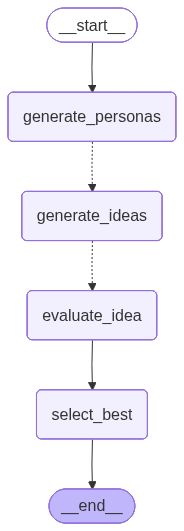

In [ ]:
from IPython.display import Image

graph = StateGraph(OverallState)

graph.add_node("generate_personas", generate_personas)
graph.add_node("generate_ideas", generate_ideas)
graph.add_node("evaluate_idea", evaluate_idea)
graph.add_node("select_best", select_best)

graph.add_edge(START, "generate_personas")
graph.add_conditional_edges("generate_personas", continue_to_ideas, ["generate_ideas"])
graph.add_conditional_edges("generate_ideas", continue_to_evaluations, ["evaluate_idea"])
graph.add_edge("evaluate_idea", "select_best")
graph.add_edge("select_best", END)

app = graph.compile()
Image(app.get_graph().draw_mermaid_png())


In [ ]:
input_state = {"product": "SmartNote (AI note-taking app)"}

final_state = None
for s in app.stream(input_state):
    print(s)
    final_state = s

print("\n--- Final reduced results ---")
# if `app.run` is available use it for final consolidated result
try:
    res = app.run(input_state)
    print(json.dumps(res, indent=2))
except Exception:
    print("Streaming final state above; check 'best_per_persona' and 'best_overall' in the last printed states.")


{'generate_personas': {'personas': ['busy college student', 'knowledge‑driven researcher', 'organized remote professional']}}
{'generate_ideas': {'ideas': [{'idea': 'AI‑generated lecture summaries: upload audio or video recordings and get a concise, bullet‑point recap within minutes.', 'persona': 'busy college student'}, {'idea': 'Smart study scheduler: automatically sync class timetables, assign study blocks, and remind you to review notes before exams.', 'persona': 'busy college student'}, {'idea': 'Contextual citation helper: detect sources in your notes, generate proper citations, and create a bibliography on the fly.', 'persona': 'busy college student'}]}}
{'generate_ideas': {'ideas': [{'idea': "AI‑driven meeting summarizer that auto‑generates structured notes, action items, and follow‑up reminders synced to the user's calendar.", 'persona': 'organized remote professional'}, {'idea': 'Smart workspace organizer that tags, categorizes, and groups notes by project, client, or deadlin